In [1]:
import numpy as np
from skimage import data, io, filters
from matplotlib import pyplot as plt
from PIL import Image
from skimage.transform import resize
import random
%matplotlib inline

Dimensions of the image are: (191, 384)


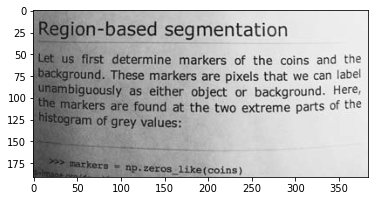

In [63]:
img = data.page()
print("Dimensions of the image are:", img.shape)
plt.imshow(img, cmap='gray')

In [64]:
def binarize_img(img):
    bin_img = img / 255.

    bin_img.flags.writeable = True
    bin_img[bin_img <= 0.5] = 0
    bin_img[bin_img > 0.5] = 1

    return bin_img

dimensions:  (191, 384)


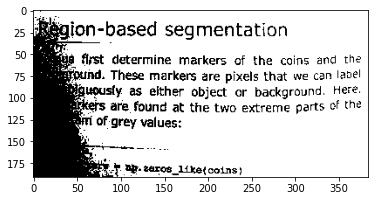

In [65]:
bin_img = binarize_img(img)
print("dimensions: ", bin_img.shape)
plt.imshow(bin_img, cmap='gray')

In [66]:
def add_noise(original_img, thresh=0.01):

    N, M = original_img.shape
    noisy_img = original_img.copy()
    noise = np.random.rand(N, M)
    noise[noise <= 1-thresh] = 0
    noise[noise > 1-thresh] = 1
    noisy_img = (noisy_img + noise) % 2
    
    return noisy_img

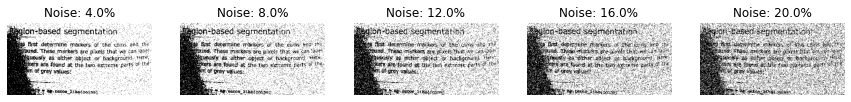

In [67]:
fig = plt.figure(figsize=(15, 8))

for i in range(1, 6):
  thresh = i/25
  noisy_img = add_noise(bin_img, thresh)
  plt.subplot(1, 5, i)
  plt.title(f'Noise: {thresh*100}%')
  plt.axis('off')
  plt.imshow(noisy_img, cmap='gray')
plt.show()

In [68]:
def get_neighbours(i, j, M, N):
    neighbours = []
    if i > 0:
        neighbours.append([i-1, j])
    if i < M-1:
        neighbours.append([i+1, j])
    if j > 0:
        neighbours.append([i, j-1])
    if j < N-1:
        neighbours.append([i, j+1])

    return neighbours

In [69]:
def enrg(new, old, y, neighbours):
    lmda = -100
    return (new - old)**2 + lmda * np.sum((new - y[neighbour[0], neighbour[1]])**2 for neighbour in neighbours)

In [70]:
def diff(y, y_old):
    diff = abs(y - y_old) / 2
    return (100.0 * np.sum(diff)) / np.size(y)

In [71]:
def denoise(noisy_img):
    M, N = noisy_img.shape
    y = noisy_img.copy()
    maxiter = 2*M*N

    for iter in range(maxiter):
        i = np.random.randint(M)
        j = np.random.randint(N)
        neighbours = get_neighbours(i, j, M, N)

        enrg_1 = enrg(1, y[i, j], y, neighbours)
        enrg_0 = enrg(0, y[i, j], y, neighbours)

        if enrg_1 > enrg_0:
            y[i, j] = 1
        else:
            y[i, j] = 0
        
        if iter % 1500000 == 0:
            print (f'Completed {iter} iterations out of {maxiter}. Denoized pixels are: {diff(y, noisy_img)}%')

    return y

Denoising for noise level: 4.0
Completed 0 iterations out of 146688. Denoized pixels are: 0.0006817190226876091%


<ipython-input-69-9ba646691f8f>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  return (new - old)**2 + lmda * np.sum((new - y[neighbour[0], neighbour[1]])**2 for neighbour in neighbours)


Denoising for noise level: 8.0
Completed 0 iterations out of 146688. Denoized pixels are: 0.0%
Denoising for noise level: 12.0
Completed 0 iterations out of 146688. Denoized pixels are: 0.0%



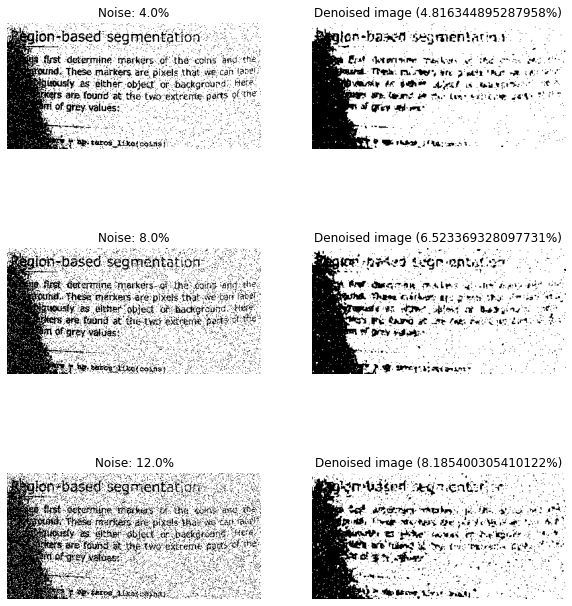

In [76]:
fig = plt.figure(figsize=(10, 20))

for i in range(1, 4):
  thresh = i/25
  print(f"Denoising for noise level: {thresh*100}")

  noisy_img = add_noise(bin_img, thresh)
  denoised_img = denoise(noisy_img)

  plt.subplot(5, 2, 2*i-1)
  plt.title(f'Noise: {thresh*100}%')
  plt.axis('off')
  plt.imshow(noisy_img, cmap='gray')

  plt.subplot(5, 2, 2*i)
  plt.title(f'Denoised image ({diff(noisy_img, denoised_img)}%)')
  plt.axis('off')
  plt.imshow(denoised_img, cmap='gray')

print()
plt.show()

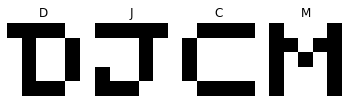

In [77]:
# Patterns to store

D = np.array([-1, -1, -1, -1, 1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1]).reshape(5,5)
J = np.array([-1, -1, -1, -1, -1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, -1, 1, -1, -1, -1, 1, 1]).reshape(5,5)
C = np.array([1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, -1, 1, 1, 1, 1, 1, -1, -1, -1, -1]).reshape(5,5)
M = np.array([-1, 1, 1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 1, 1, -1]).reshape(5,5)

X = np.array([D, J, C, M])

letters = ['D', 'J', 'C', 'M']

fig = plt.figure(figsize=(6, 6))

for idx, letter in enumerate(X):
    plt.subplot(1, 4, idx+1)
    plt.title(letters[idx])
    plt.axis('off')
    plt.imshow(letter, cmap='gray')
plt.show()

In [78]:
# Learn the weights according to Hebb's rule

n = X.shape[0]
m = X.shape[1] * X.shape[2]

W = np.zeros((m,m));
for i in range(n):
	W += X[i, :].reshape(-1, 1) @  X[i, :].reshape(1, -1)

np.fill_diagonal(W, 0)

W /= n

In [79]:
def add_error(num_errors=1):
    chosen_letter = random.choice(X)
    letter_with_err = chosen_letter.copy()
    errors = []
    while num_errors:
        i = np.random.randint(5)
        j = np.random.randint(5)

        if (i, j) not in errors:
            errors.append((i, j))
            letter_with_err[i, j] = -letter_with_err[i, j]
            num_errors -= 1

    return chosen_letter, letter_with_err

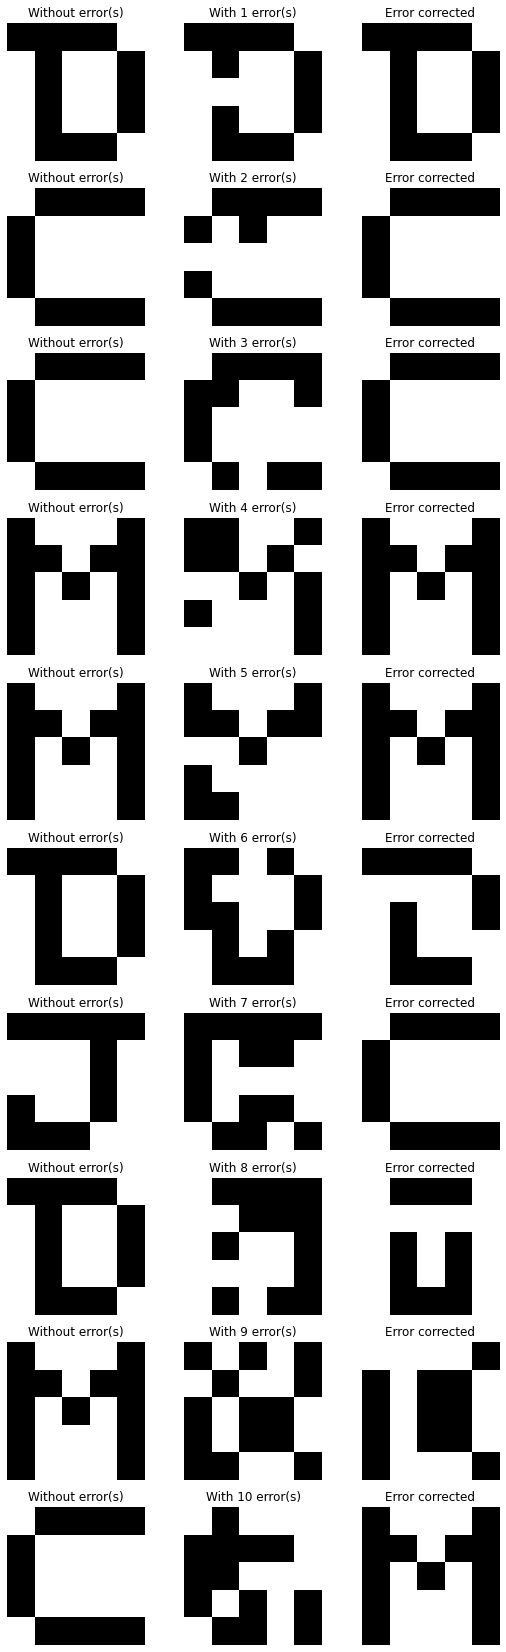

In [80]:
# Removing errors

fig = plt.figure(figsize=(9, 45))

for i in range(1, 10 + 1):
    chosen_letter, letter_with_err = add_error(i)

    y = letter_with_err.reshape(-1)

    last_erry = 0
    erry = 26
    while erry != last_erry:
        last_erry = erry
        yp = np.sign(W @ y)
        erry = np.linalg.norm(yp - y)
        y = yp
    
    plt.subplot(15, 3, 3*(i-1)+1)
    plt.title('Without error(s)')
    plt.axis('off')
    plt.imshow(chosen_letter, cmap='gray')
    plt.subplot(15, 3, 3*(i-1)+2)
    plt.title(f'With {i} error(s)')
    plt.axis('off')
    plt.imshow(letter_with_err, cmap='gray')
    plt.subplot(15, 3, 3*(i-1)+3)
    plt.title('Error corrected')
    plt.axis('off')
    plt.imshow(y.reshape(5,5), cmap='gray')
plt.show()

In [96]:
# Number of cities
N = 10

city_x = np.random.rand((10))
city_y = np.random.rand((10))

print('The co-ordinates of the 10 cities are:')
for city in zip(city_x, city_y):
    print(city)

The co-ordinates of the 10 cities are:
(0.9338770737008487, 0.3986069733124523)
(0.7877925970453602, 0.5010149955675004)
(0.22155925863349712, 0.07395945739625731)
(0.45005988916716655, 0.009812219496474928)
(0.5970408326486488, 0.8723816503955208)
(0.8134176446956345, 0.8983845575324391)
(0.6495414081678609, 0.9459494682107371)
(0.8985306350618343, 0.18880917016116694)
(0.29542344479892646, 0.2612073743918485)
(0.7215155367667716, 0.9393572672582283)


Text(0.5, 1.0, 'Map of cities')

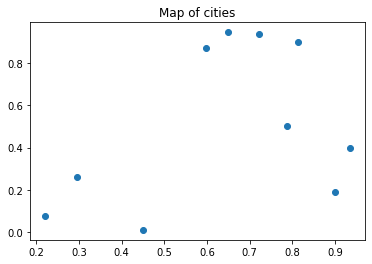

In [97]:
plt.plot(city_x, city_y, 'o')
plt.title('Map of cities')

In [98]:
d = np.zeros((N,N))
# Calculate distance matrix
for i in range(N):
    for j in range(N):
        d[i, j] = np.sqrt((city_x[i] - city_x[j])**2 + (city_y[i] - city_y[j])**2)

In [99]:
# Set parameters for network energy function
A = 500
B = 500
C = 1000
D = 500
alpha = 0.00001

In [100]:
# x-v-value of each node, y-u-input potential, u0-gamma
def hopfield():
    u0 = 0.02
    toend = 0
    udao = np.zeros((N, N))
    ctr = 0
    while toend == 0:
        ctr += 1
        # U initialization
        v = np.random.rand(N,N)
        u = np.ones([N, N])*(-u0*np.log(N-1)/2)

        u += u*0.91
        for _ in range(1000):
            for vx in range(N):
                for vi in range(N):
                    j1, j2, j3, j4 = 0, 0, 0, 0

                    # derivative 1 (sum over columns j!=vi)
                    for j in range(N):
                        if j != vi:
                            j1 += v[vx, j]
                    j1 *= -A

                    # derivative 2 (sum over rows y!=x)
                    for y in range(N):
                        if y != vx:
                            j2 += v[y, vi]
                    j2 *= -B

                    # derivative 3 (overall sum)
                    j3 = np.sum(v)
                    j3 = -C*(j3-N)

                    # derivative 4
                    for y in range(N):
                        if y != vx:
                            if vi == 0:
                                j4 += d[vx, y]*(v[y, vi+1]+v[y, N-1])
                            elif vi == N-1:
                                j4 += d[vx, y]*(v[y, vi-1]+v[y, 0])
                            else:
                                j4 += d[vx, y]*(v[y, vi+1]+v[y, vi-1])
                    j4 *= -D
                    udao[vx, vi] = -u[vx, vi]+j1+j2+j3+j4

            # update status and derivatives
            u = u + alpha*udao

            # calculate node value from input potential u
            v = (1+np.tanh(u/u0)) / 2

            # threshold
            for vx in range(N):
                for vi in range(N):
                    if(v[vx, vi] < 0.7):
                        v[vx, vi] = 0
                    if(v[vx, vi] >= 0.7):
                        v[vx, vi]=1

        # testing whether solution is legal
        t1, t2, t3 = 0, 0, 0

        # require total of N-nodes with 1 value
        t1=0;
        for vx in range(N):
            for vi in range(N):
                t1+=v[vx, vi]

        # allow only one node in each row equal 1
        t2=0
        for x in range(N):
            for i in range(N-1):
                for j in range(i+1, N):
                    t2+=np.multiply(v[x, i], v[x, j])

        # allow only one node in each column equal 1
        t3=0
        for i in range(N):
            for x in range(N-1):
                for y in range(x+1, N):
                    t3+=np.multiply(v[x, i], v[y, i])

        # stop the loop after getting the valid solution
        if t1 == N and t2 == 0 and t3 == 0:
            toend = 1
        else:
            toend = 0

    return(v, ctr)


In [101]:
def total_distance(v):
    city_x_final = np.zeros((N+1))
    city_y_final = np.zeros((N+1))

    for j in range(N):
        for i in range(N):
            if v[i,j] == 1:
                city_x_final[j] = city_x[i]
                city_y_final[j] = city_y[i]

    city_x_final[N] = city_x_final[0]
    city_y_final[N] = city_y_final[0]

    # calculate the total distance
    td = 0
    for i in range(N-1):
        td += np.sqrt((city_x_final[i] - city_x_final[i+1])**2
                    + (city_y_final[i] - city_y_final[i+1])**2)
    td += np.sqrt((city_x_final[N-1] - city_x_final[0])**2
                + (city_y_final[N-1] - city_y_final[0])**2)
    
    return(td, city_x_final, city_y_final)

In [102]:
v = np.zeros([N,N])

ct = 0

min_dist = 20
best_path = None

for i in range(5):
    v, steps = hopfield()
    td, _, _ = total_distance(v)
    print(f"Epoch {i}: Ran for {steps} steps, total distance {td}")
    if td < min_dist:
        min_dist = td
        best_path = v
print(min_dist)
print(best_path)

Epoch 0: Ran for 1 steps, total distance 2.9246963890075905
Epoch 1: Ran for 13 steps, total distance 3.1440690387383965
Epoch 2: Ran for 10 steps, total distance 3.261070118798064
Epoch 3: Ran for 1 steps, total distance 3.048495028939249
Epoch 4: Ran for 8 steps, total distance 3.0416530065035214
2.9246963890075905
[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]


In [103]:
def get_route(v):
    route = ""
    for j in range(v.shape[1]):
        route += str(np.argmax(v[:, j])) + ' -> '
    return (route + str(np.argmax(v[:, 0])))

In [105]:
print(get_route(best_path))

1 -> 8 -> 2 -> 3 -> 7 -> 0 -> 4 -> 6 -> 9 -> 5 -> 1


In [104]:
def get_route_indices(v):
    indices = []
    for j in range(v.shape[1]):
        indices.append(np.argmax(v[:, j]))
    indices.append(np.argmax(v[:, 0]))
    return indices

In [106]:
indices = get_route_indices(best_path)
print(indices)

[1, 8, 2, 3, 7, 0, 4, 6, 9, 5, 1]


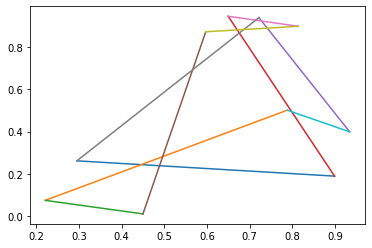

In [107]:
for i in indices[1:]:
    plt.plot([city_x[i], city_x[i-1]], [city_y[i], city_y[i-1]], '-')
plt.show()